# JIT compilation and parallelization with Numba

This is a topical tutorial. If you are new to iminuit, you should go through the basic tutorial first. 

The time that iminuit requires to return a result, if that time is perceptible, is usually dominated by the execution time of the cost function. To get good performance, it recommended to use array arthimetic and scipy and numpy functions in the body of the cost function. Python loops should be avoided, but if they are unavoidable, [numba](https://numba.pydata.org/) can help. Numba can also parallelize numerical calculations to make full use of multi-core CPUs.

In [1]:
# !pip install matplotlib numpy numba scipy iminuit
from iminuit import Minuit
import numpy as np
import numba as nb
import math
from scipy.stats import expon, norm
from matplotlib import pyplot as plt
from argparse import Namespace

## Generate some toy data

The standard fit in particle physics is the fit of a peak over some smooth background. We generate a Gaussian peak over exponential background, using scipy.

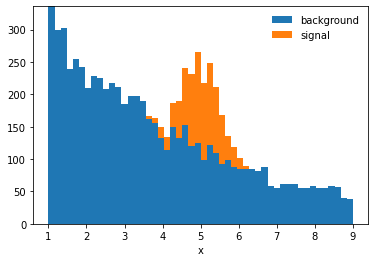

In [2]:
np.random.seed(1)  # fix seed

# true parameters for signal and background
truth = Namespace(n_sig=1000, f_bkg=10, sig=(5.0, 0.5), bkg=(0.0, 4.0))
n_bkg = truth.n_sig * truth.f_bkg

# make a data set
x = np.empty(truth.n_sig + n_bkg)

# fill m variables
x[:truth.n_sig] = norm(*truth.sig).rvs(truth.n_sig)
x[truth.n_sig:] = expon(*truth.bkg).rvs(n_bkg)

# cut a range in x
xrange = np.array((1.0, 9.0))
ma = (xrange[0] < x) & (x < xrange[1])
x = x[ma]

plt.hist((x[truth.n_sig:], x[:truth.n_sig]), bins=50, stacked=True, label=("background", "signal"))
plt.xlabel("x")
plt.legend();

In [3]:
# ideal starting values for iminuit
start = np.array((truth.n_sig, n_bkg, truth.sig[0], truth.sig[1], truth.bkg[1]))


# iminuit instance factory, will be called a lot in the benchmarks blow
def m_init(fcn):
    return Minuit.from_array_func(fcn,
                                  start,
                                  limit=((0, None), (0, None), None, (0, None),
                                         (0, None)),
                                  name=("ns", "nb", "mu", "sigma", "lambd"),
                                  errordef=Minuit.LIKELIHOOD,
                                  pedantic=False)

In [4]:
# extended likelihood (https://doi.org/10.1016/0168-9002(90)91334-8)
# this version uses numpy and scipy and array arithmetic
def nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    s = norm(mu, sigma)
    b = expon(0, lambd)
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = s.cdf(xrange)
    bn = b.cdf(xrange)
    sn = sn[1] - sn[0]
    bn = bn[1] - bn[0]
    return (n_sig + n_bkg) - np.sum(np.log(s.pdf(x) / sn * n_sig + b.pdf(x) / bn * n_bkg))


nll(start)

-46424.886640130324

In [5]:
%%timeit -r 3 -n 1
m = m_init(nll) # setup time is negligible
m.migrad();

334 ms ± 5.66 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


About 2 seconds on this computer. Let's see whether we can beat that. The code above is already pretty fast, because numpy and scipy routines are fast, and we spend most of the time in those. But these implementations do not parallelize the execution and are not optimised for this particular CPU, unlike numba-jitted functions.

To use numba, in theory we just need to put the `njit` decorator on top of the function, but often that doesn't work out of the box. numba understands many numpy functions, but no scipy. We must evaluate the code that uses scipy in 'object mode', which is numba-speak for calling into the Python interpreter.

In [6]:
# first attempt to use numba
@nb.njit(parallel=True)
def jitted_nll_simple(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    with nb.objmode(spdf="float64[:]", bpdf="float64[:]", sn="float64", bn="float64"):
        s = norm(mu, sigma)
        b = expon(0, lambd)
        # normalisation factors are needed for pdfs, since x range is restricted
        sn = np.diff(s.cdf(xrange))[0]
        bn = np.diff(b.cdf(xrange))[0]
        spdf = s.pdf(x)
        bpdf = b.pdf(x)
    no = n_sig + n_bkg
    return no - np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))

jitted_nll_simple(start) # test and warm-up JIT

-46424.88664013033

In [7]:
%%timeit -r 3 -n 10
m = m_init(jitted_nll_simple)
m.migrad()

368 ms ± 9.69 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


It is only marginally faster. Let's break the original function down by parts to see why.

In [8]:
# let's time the body of the function
n_sig, n_bkg, mu, sigma, lambd = start
s = norm(mu, sigma)
b = expon(0, lambd)
# normalisation factors are needed for pdfs, since x range is restricted
sn = np.diff(s.cdf(xrange))[0]
bn = np.diff(b.cdf(xrange))[0]
spdf = s.pdf(x)
bpdf = b.pdf(x)
no = n_sig + n_bkg
# no - np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))

%timeit -r 5 -n 50 norm(*start[2:4]).pdf(x)
%timeit -r 5 -n 50 expon(0, start[4]).pdf(x)
%timeit -r 5 -n 50 np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))

1.22 ms ± 89.7 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
1.11 ms ± 43.8 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
246 µs ± 3.17 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


Most of the time is spend in those parts that numba could not accelerate and the total time is dominated by the slowest part.

This, unfortunately, means we have to do much more manual work to make the function faster, since we have to replace the scipy routines with Python code that numba can accelerate and run in parallel.

In [9]:
kwd = {"parallel": True, "fastmath": True}

@nb.njit(**kwd)
def sum_log(fs, spdf, fb, bpdf):
    return np.sum(np.log(fs * spdf + fb * bpdf))


@nb.njit(**kwd)
def norm_pdf(x, mu, sigma):
    invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z**2) * invnorm


@nb.njit(**kwd)
def nb_erf(x):
    y = np.empty_like(x)
    for i in nb.prange(len(x)):
        y[i] = math.erf(x[i])
    return y


@nb.njit(**kwd)
def norm_cdf(x, mu, sigma):
    invs = 1.0 / (sigma * np.sqrt(2))
    z = (x - mu) * invs
    return 0.5 * (1 + nb_erf(z))


@nb.njit(**kwd)
def expon_pdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return inv_lambd * np.exp(-inv_lambd * x)


@nb.njit(**kwd)
def expon_cdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return 1.0 - np.exp(-inv_lambd * x)


def jitted_nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = norm_cdf(xrange, mu, sigma)
    bn = expon_cdf(xrange, lambd)
    sn = sn[1] - sn[0]
    bn = bn[1] - bn[0]
    spdf = norm_pdf(x, mu, sigma)
    bpdf = expon_pdf(x, lambd)
    no = n_sig + n_bkg
    return no - sum_log(n_sig / sn, spdf, n_bkg / bn, bpdf)


jitted_nll(start)  # test and warm-up JIT

-46424.886640130324

In [10]:
%%timeit -r 5 -n 50
m = m_init(jitted_nll)
m.migrad()

93.9 ms ± 5.73 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


We managed to get a **4x** speed improvement over the initial code, which is impressive, but it cost us a lot of developer time. By putting these functions into a library, however, we only have to pay the developer cost once. We close with a breakdown of how numba accelerated the parts of `jitted_nll`. 

In [11]:
%timeit -r 5 -n 50 norm_pdf(x, *start[2:4])
%timeit -r 5 -n 50 expon_pdf(x, start[4])
%timeit -r 5 -n 50 sum_log(n_sig / sn, spdf, n_bkg / bn, bpdf)

300 µs ± 121 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
156 µs ± 6.58 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)
257 µs ± 136 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


As expected, the total speed improvement mostly came from the acceleration of the normal and exponential pdfs, which got more than 4x faster, while the final sum was only accelerated by a factor of about two.